In [ ]:
import os

# defining directories and subdirectories
dataset_home = 'dataset_dogs_vs_cats/'
subdirs = ['train/', 'test/']

for subdir in subdirs:
    # creating label subdirectories
    labeldirs = ['dogs/', 'cats/']
    for labeldir in labeldirs:
        newdir = dataset_home + subdir + labeldir
        os.makedirs(newdir, exist_ok=True)


In [ ]:
import shutil
import random
import cv2

# defining ratio for validation set
val_ratio = 0.25

src_dir = 'train'

for file in os.listdir(src_dir):
    src = os.path.join(src_dir, file)
    #img = cv2.imread(src, cv2.COLOR_BGR2GRAY)
    dst_dir = 'train'
    if random.random() < val_ratio:
        dst_dir = 'test'
    if file.startswith('cat'):
        #cv2.imwrite(os.path.join(dataset_home, dst_dir, 'cats', file), img)
        shutil.copyfile(src, os.path.join(dataset_home, dst_dir, 'cats', file))
    elif file.startswith('dog'):
        #cv2.imwrite(os.path.join(dataset_home, dst_dir, 'dogs', file), img)
        shutil.copyfile(src, os.path.join(dataset_home, dst_dir, 'dogs', file))


A good starting point is the general architectural principles of the VGG models. These are a good starting point because they achieved top performance in the ILSVRC 2014 competition and because the modular structure of the architecture is easy to understand and implement. For more details on the VGG model, see the 2015 paper [“Very Deep Convolutional Networks for Large-Scale Image Recognition.”](https://arxiv.org/abs/1409.1556)

The architecture involves stacking convolutional layers with small 3×3 filters followed by a max pooling layer. Together, these layers form a block, and these blocks can be repeated where the number of filters in each block is increased with the depth of the network such as 32, 64, 128, 256 for the first four blocks of the model. Padding is used on the convolutional layers to ensure the height and width shapes of the output feature maps matches the inputs.

[Source](https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-to-classify-photos-of-dogs-and-cats/)

In [2]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16


## One Block VGG Model

The one-block VGG model has a single convolutional layer with 32 filters followed by a max pooling layer.

Found 18832 images belonging to 2 classes.
Found 6168 images belonging to 2 classes.
Epoch 1/20
295/295 [==============================] - 753s 3s/step - loss: 0.6874 - accuracy: 0.5612 - val_loss: 0.7079 - val_accuracy: 0.5232
Epoch 2/20
295/295 [==============================] - 39s 133ms/step - loss: 0.6609 - accuracy: 0.5998 - val_loss: 0.6445 - val_accuracy: 0.6284
Epoch 3/20
295/295 [==============================] - 43s 147ms/step - loss: 0.6442 - accuracy: 0.6193 - val_loss: 0.6341 - val_accuracy: 0.6302
Epoch 4/20
295/295 [==============================] - 41s 137ms/step - loss: 0.6407 - accuracy: 0.6265 - val_loss: 0.6276 - val_accuracy: 0.6433
Epoch 5/20
295/295 [==============================] - 43s 144ms/step - loss: 0.6323 - accuracy: 0.6319 - val_loss: 0.6260 - val_accuracy: 0.6396
Epoch 6/20
295/295 [==============================] - 46s 154ms/step - loss: 0.6223 - accuracy: 0.6439 - val_loss: 0.6188 - val_accuracy: 0.6443
Epoch 7/20
295/295 [===========================

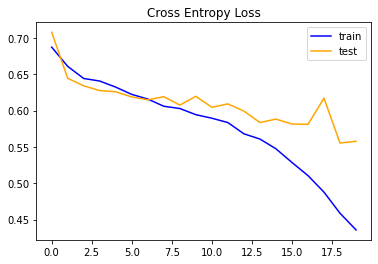

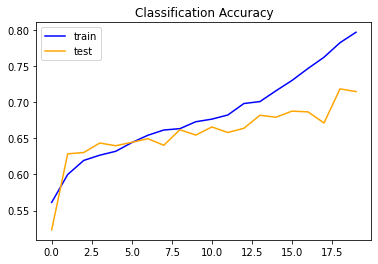

In [3]:
# define a baseline CNN model
def define_model():
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu',
              kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(units=128, activation='relu',
              kernel_initializer='he_uniform'))
              
    model.add(Dense(units=1, activation='sigmoid'))
    # compiling model
    opt = SGD(learning_rate=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# plotting diagnostic curves


def summarize_diagnostics(history):
    # plot loss
    # plt.subplot(121)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='test')
    plt.legend()
    plt.show()

    # plot accuracy
    # plt.subplot(122)
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='orange', label='test')
    plt.legend()
    plt.show()


def run_test_harness():
    # define model
    model = define_model()
    # create data generator
    datagen = ImageDataGenerator(rescale=1.0/255.0)
    # prepare iterator
    train_it = datagen.flow_from_directory(
        directory='dataset_dogs_vs_cats/train/', class_mode='binary', batch_size=64, target_size=(200, 200), color_mode='grayscale')
    test_it = datagen.flow_from_directory(
        'dataset_dogs_vs_cats/test/', class_mode='binary', batch_size=64, target_size=(200, 200), color_mode='grayscale')
    # fit model
    history = model.fit(train_it, steps_per_epoch=len(
        train_it), validation_data=test_it, validation_steps=len(test_it), epochs=20, verbose=1)
    # evaluate model
    _, acc = model.evaluate(test_it, steps=len(test_it), verbose=1)
    print('> %.3f' % (acc * 100.0))
    # learning curves
    summarize_diagnostics(history)


# entry point, run the test harness
run_test_harness()


## Three Block VGG Model

The three-block VGG model extends the one block model and adds a second block with 64 filters and a third block with 128 filters.

Found 18832 images belonging to 2 classes.
Found 6168 images belonging to 2 classes.
97/97 [==============================] - 15s 151ms/step - loss: 0.7056 - accuracy: 0.7662
> 76.621
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 200, 200, 32)      320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 100, 100, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 100, 100, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 50, 50, 64)       0         
 2D)                                                             
                                                                 
 c

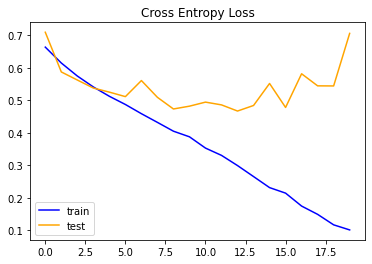

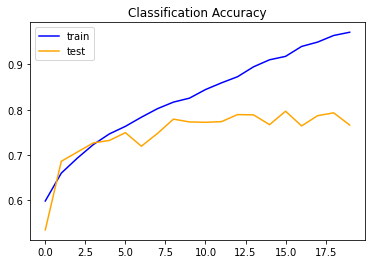

In [5]:
def define_model():
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu',
              kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu',
              kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu',
              kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(units=128, activation='relu',
              kernel_initializer='he_uniform'))
              
    model.add(Dense(units=1, activation='sigmoid'))
    # compiling model
    opt = SGD(learning_rate=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# plotting diagnostic curves


def summarize_diagnostics(history):
    # plot loss
    # plt.subplot(121)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='test')
    plt.legend()
    plt.show()

    # plot accuracy
    # plt.subplot(122)
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='orange', label='test')
    plt.legend()
    plt.show()


def run_test_harness():
    # define model
    model = define_model()
    # create data generator
    datagen = ImageDataGenerator(rescale=1.0/255.0)
    # prepare iterator
    train_it = datagen.flow_from_directory(
        directory='dataset_dogs_vs_cats/train/', class_mode='binary', batch_size=64, target_size=(200, 200), color_mode='grayscale')
    test_it = datagen.flow_from_directory(
        'dataset_dogs_vs_cats/test/', class_mode='binary', batch_size=64, target_size=(200, 200), color_mode='grayscale')
    # fit model
    history = model.fit(train_it, steps_per_epoch=len(
        train_it), validation_data=test_it, validation_steps=len(test_it), epochs=20, verbose=0)
    # evaluate model
    _, acc = model.evaluate(test_it, steps=len(test_it), verbose=1)
    print('> %.3f' % (acc * 100.0))
    model.summary()
    # learning curves
    summarize_diagnostics(history)


# entry point, run the test harness
run_test_harness()


We see a trend of improved performance with the increase in capacity, but also a similar case of overfitting occurring earlier and earlier in the run. The results suggest that the model will likely benefit from *regularization techniques.*  
This may include techniques such as *dropout, weight decay, and data augmentation.* The latter can also boost performance by encouraging the model to learn features that are further invariant to position by expanding the training dataset.

## Adding Dropout

A dropout of 20% is applied after each VGG block, with a larger dropout rate of 50% applied after the fully connected layer in the classifier part of the model.

Found 18832 images belonging to 2 classes.
Found 6168 images belonging to 2 classes.
97/97 [==============================] - 13s 131ms/step - loss: 0.4486 - accuracy: 0.8009
> 80.091
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 200, 200, 32)      320       
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 100, 100, 32)     0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 100, 100, 32)      0         
                                                                 
 conv2d_12 (Conv2D)          (None, 100, 100, 64)      18496     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 50, 50, 64)       0         
 g

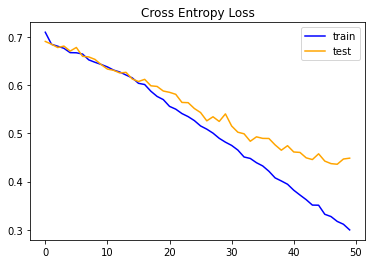

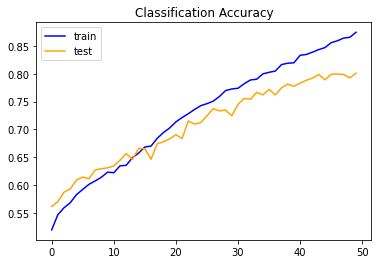

In [9]:
def define_model():
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu',
              kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu',
              kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu',
              kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(units=128, activation='relu',
              kernel_initializer='he_uniform'))
    model.add(Dropout(0.5))
    model.add(Dense(units=1, activation='sigmoid'))
    # compiling model
    opt = SGD(learning_rate=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# plotting diagnostic curves


def summarize_diagnostics(history):
    # plot loss
    # plt.subplot(121)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='test')
    plt.legend()
    plt.show()

    # plot accuracy
    # plt.subplot(122)
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='orange', label='test')
    plt.legend()
    plt.show()


def run_test_harness():
    # define model
    model = define_model()
    # create data generator
    datagen = ImageDataGenerator(rescale=1.0/255.0)
    # prepare iterator
    train_it = datagen.flow_from_directory(
        directory='dataset_dogs_vs_cats/train/', class_mode='binary', batch_size=64, target_size=(200, 200), color_mode='grayscale')
    test_it = datagen.flow_from_directory(
        'dataset_dogs_vs_cats/test/', class_mode='binary', batch_size=64, target_size=(200, 200), color_mode='grayscale')
    # fit model
    history = model.fit(train_it, steps_per_epoch=len(
        train_it), validation_data=test_it, validation_steps=len(test_it), epochs=50, verbose=0)
    # evaluate model
    _, acc = model.evaluate(test_it, steps=len(test_it), verbose=1)
    print('> %.3f' % (acc * 100.0))
    model.summary()
    # learning curves
    summarize_diagnostics(history)


# entry point, run the test harness
run_test_harness()


Reviewing the learning curves, we can see that dropout has had an effect on the rate of improvement of the model on both the train and test sets.
Overfitting has been reduced or delayed, although performance may begin to stall towards the end of the run.
The results suggest that further training epochs may result in further improvement of the model.

## Image Data Augmentation

Image data augmentation is a technique that can be used to artificially expand the size of a training dataset by creating modified versions of images in the dataset.  
Data augmentation can also act as a regularization technique, adding noise to the training data, and encouraging the model to learn the same features, invariant to their position in the input.

In this case, photos in the training dataset will be augmented with small (10%) random horizontal and vertical shifts and random horizontal flips that create a mirror image of a photo. Photos in both the train and test steps will have their pixel values scaled in the same way.

Found 18832 images belonging to 2 classes.
Found 6168 images belonging to 2 classes.
Epoch 1/50
295/295 [==============================] - 85s 284ms/step - loss: 0.6822 - accuracy: 0.5579 - val_loss: 0.6625 - val_accuracy: 0.5780
Epoch 2/50
295/295 [==============================] - 92s 311ms/step - loss: 0.6504 - accuracy: 0.6165 - val_loss: 0.6178 - val_accuracy: 0.6521
Epoch 3/50
295/295 [==============================] - 97s 326ms/step - loss: 0.6332 - accuracy: 0.6364 - val_loss: 0.6044 - val_accuracy: 0.6693
Epoch 4/50
295/295 [==============================] - 108s 365ms/step - loss: 0.6145 - accuracy: 0.6571 - val_loss: 0.5788 - val_accuracy: 0.6900
Epoch 5/50
295/295 [==============================] - 98s 331ms/step - loss: 0.5863 - accuracy: 0.6859 - val_loss: 0.5615 - val_accuracy: 0.6994
Epoch 6/50
295/295 [==============================] - 98s 331ms/step - loss: 0.5679 - accuracy: 0.7011 - val_loss: 0.5391 - val_accuracy: 0.7185
Epoch 7/50
295/295 [========================

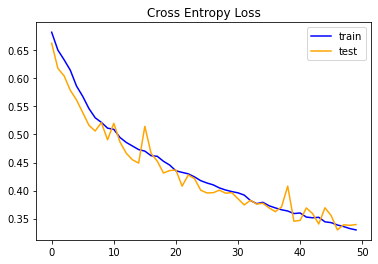

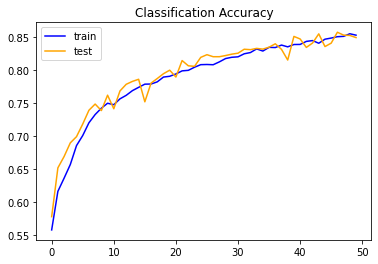

In [12]:
def define_model():
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu',
              kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu',
              kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu',
              kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(units=128, activation='relu',
              kernel_initializer='he_uniform'))
    model.add(Dense(units=1, activation='sigmoid'))
    # compiling model
    opt = SGD(learning_rate=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# plotting diagnostic curves


def summarize_diagnostics(history):
    # plot loss
    # plt.subplot(121)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='test')
    plt.legend()
    plt.show()

    # plot accuracy
    # plt.subplot(122)
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='orange', label='test')
    plt.legend()
    plt.show()


def run_test_harness():
    # define model
    model = define_model()
    # create data generator
    train_datagen = ImageDataGenerator(
        width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True, rescale=1.0/255.0)
    test_datagen = ImageDataGenerator(rescale=1.0/255.0)
    # prepare iterator
    train_it = train_datagen.flow_from_directory(
        directory='dataset_dogs_vs_cats/train/', class_mode='binary', batch_size=64, target_size=(200, 200), color_mode='grayscale')
    test_it = test_datagen.flow_from_directory(
        'dataset_dogs_vs_cats/test/', class_mode='binary', batch_size=64, target_size=(200, 200), color_mode='grayscale')
    # fit model
    history = model.fit(train_it, steps_per_epoch=len(
        train_it), validation_data=test_it, validation_steps=len(test_it), epochs=50, verbose=1)
    # evaluate model
    _, acc = model.evaluate(test_it, steps=len(test_it), verbose=1)
    print('> %.3f' % (acc * 100.0))
    model.summary()
    # learning curves
    summarize_diagnostics(history)


# entry point, run the test harness
run_test_harness()


As expected, the addition of regularization techniques slows the progression of the learning algorithms and reduces overfitting, resulting in improved performance on the holdout dataset. It is likely that the combination of both approaches with further increase in the number of training epochs will result in further improvements.

## Transfer Learning

Transfer learning involves using all or parts of a model trained on a related task.

Keras provides a range of pre-trained models that can be loaded and used wholly or partially via the Keras Applications API.

A useful model for transfer learning is one of the VGG models, such as VGG-16 with 16 layers that at the time it was developed, achieved top results on the ImageNet photo classification challenge.

The model is comprised of two main parts, the feature extractor part of the model that is made up of VGG blocks, and the classifier part of the model that is made up of fully connected layers and the output layer.

We can use the feature extraction part of the model and add a new classifier part of the model that is tailored to the dogs and cats dataset. Specifically, we can hold the weights of all of the convolutional layers fixed during training, and only train new fully connected layers that will learn to interpret the features extracted from the model and make a binary classification.

The VGG16 model was trained on a specific ImageNet challenge dataset. As such, it is configured to expected input images to have the shape 224×224 pixels. We will use this as the target size when loading photos from the dogs and cats dataset.

The model also expects images to be centered. That is, to have the mean pixel values from each channel (red, green, and blue) as calculated on the ImageNet training dataset subtracted from the input. Keras provides a function to perform this preparation for individual photos via the preprocess_input() function. Nevertheless, we can achieve the same effect with the ImageDataGenerator by setting the “featurewise_center” argument to “True” and manually specifying the mean pixel values to use when centering as the mean values from the ImageNet training dataset: [123.68, 116.779, 103.939]

Found 18832 images belonging to 2 classes.
Found 6168 images belonging to 2 classes.
Epoch 1/10
295/295 [==============================] - 221s 749ms/step - loss: 0.2044 - accuracy: 0.9643 - val_loss: 0.0794 - val_accuracy: 0.9754
Epoch 2/10
295/295 [==============================] - 209s 707ms/step - loss: 0.0279 - accuracy: 0.9895 - val_loss: 0.0842 - val_accuracy: 0.9745
Epoch 3/10
295/295 [==============================] - 211s 716ms/step - loss: 0.0066 - accuracy: 0.9986 - val_loss: 0.0984 - val_accuracy: 0.9781
Epoch 4/10
295/295 [==============================] - 213s 721ms/step - loss: 0.0017 - accuracy: 0.9997 - val_loss: 0.1073 - val_accuracy: 0.9786
Epoch 5/10
295/295 [==============================] - 216s 732ms/step - loss: 8.1541e-04 - accuracy: 0.9999 - val_loss: 0.1141 - val_accuracy: 0.9786
Epoch 6/10
295/295 [==============================] - 216s 732ms/step - loss: 5.4344e-04 - accuracy: 0.9999 - val_loss: 0.1191 - val_accuracy: 0.9784
Epoch 7/10
295/295 [===========

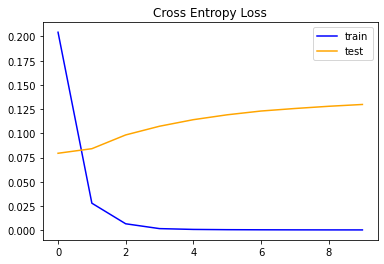

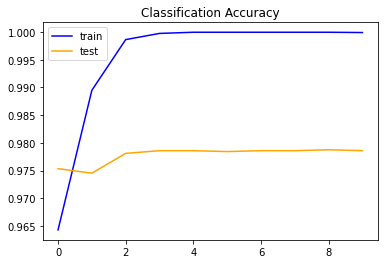

In [4]:
def define_model():
    # load model
    model = VGG16(include_top=False, input_shape=(224, 224, 3))
    # mark loaded layers as untrainable
    for layer in model.layers:
        layer.trainable = False
    # adding new classifier layers
    flat1 = Flatten()(model.layers[-1].output)
    class1 = Dense(units=128, activation='relu',
                   kernel_initializer='he_uniform')(flat1)
    output = Dense(units=1, activation='sigmoid')(class1)
    # define new model
    model = Model(inputs=model.input, outputs=output)
    # compiling model
    opt = SGD(learning_rate=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# plotting diagnostic curves


def summarize_diagnostics(history):
    # plot loss
    # plt.subplot(121)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='test')
    plt.legend()
    plt.show()

    # plot accuracy
    # plt.subplot(122)
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='orange', label='test')
    plt.legend()
    plt.show()


def run_test_harness():
    # define model
    model = define_model()
    # create data generator
    datagen = ImageDataGenerator(featurewise_center=True)
    # specifying the mean values for the ImageNet dataset
    datagen.mean = [123.68, 116.779, 103.939]
    # prepare iterator
    train_it = datagen.flow_from_directory(
        directory='dataset_dogs_vs_cats/train/', class_mode='binary', batch_size=64, target_size=(224, 224))
    test_it = datagen.flow_from_directory(
        'dataset_dogs_vs_cats/test/', class_mode='binary', batch_size=64, target_size=(224, 224))
    # fit model (training for only 10 epochs since only classifier layers are to be trained)
    history = model.fit(train_it, steps_per_epoch=len(
        train_it), validation_data=test_it, validation_steps=len(test_it), epochs=10, verbose=1)
    # evaluate model
    _, acc = model.evaluate(test_it, steps=len(test_it), verbose=1)
    print('> %.3f' % (acc * 100.0))
    model.summary()
    # learning curves
    summarize_diagnostics(history)


# entry point, run the test harness
run_test_harness()


There are many improvements that could be made to this approach, including adding dropout regularization to the classifier part of the model and perhaps even fine-tuning the weights of some or all of the layers in the feature detector part of the model.

The best model from all of the above approaches seems to be transfer learning using the VGG-16 model with an approx. accuracy of 97 percent.  
Thus, we will finalize our model by fitting a model on the entire training dataset and saving the model to file for later use. We will then load the saved model and use it to make a prediction on a single image.